<a href="https://colab.research.google.com/github/sfsf9797/ML_FROM_SCRATCH/blob/master/ImageSegmentation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# This baseline code requires a GPU device. If you have not selected the GPU runtime type, you can change the runtime type to enable GPU.

In [1]:
!pip install  --upgrade albumentations

Requirement already up-to-date: albumentations in /usr/local/lib/python3.7/dist-packages (1.0.0)


In [2]:
import os
import random
import time
import json

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import cv2

import numpy as np
import pandas as pd

# Python package for pre-processing 
from pycocotools.coco import COCO
import torchvision
import torchvision.transforms as transforms

import albumentations as A
from albumentations.pytorch import ToTensorV2

# Python package for visualization
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()



plt.rcParams['axes.grid'] = False

print('Pytorch version: {}'.format(torch.__version__))
print('Is GPU available: {}'.format(torch.cuda.is_available()))
if torch.cuda.is_available():
  print(torch.cuda.get_device_name(0))
  print('The number of GPUs available: {}'.format(torch.cuda.device_count()))
device = "cuda" if torch.cuda.is_available() else "cpu" 

print('CPU count: {}'.format(os.cpu_count()))  # 2

Pytorch version: 1.8.1+cu101
Is GPU available: True
Tesla T4
The number of GPUs available: 1
CPU count: 2


# Prepare data

In [3]:
!wget https://aistages-public-junyeop.s3.amazonaws.com/app/Competitions/000015/data/data.tar.gz
!mkdir input
!tar -xzf data.tar.gz -C ./input
!rm data.tar.gz

--2021-06-07 10:27:05--  https://aistages-public-junyeop.s3.amazonaws.com/app/Competitions/000015/data/data.tar.gz
Resolving aistages-public-junyeop.s3.amazonaws.com (aistages-public-junyeop.s3.amazonaws.com)... 52.219.58.6
Connecting to aistages-public-junyeop.s3.amazonaws.com (aistages-public-junyeop.s3.amazonaws.com)|52.219.58.6|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 490693783 (468M) [application/x-gzip]
Saving to: ‘data.tar.gz’

data.tar.gz         100%[===================>] 467.96M  16.6MB/s    in 30s     

2021-06-07 10:27:36 (15.5 MB/s) - ‘data.tar.gz’ saved [490693783/490693783]

mkdir: cannot create directory ‘input’: File exists


# Set the hyperparameters and fix the seed

In [4]:
batch_size = 8  # Mini-batch size
num_epochs = 25
learning_rate = 5e-04

In [5]:
# fix the seed
random_seed = 21
torch.manual_seed(random_seed)
torch.cuda.manual_seed(random_seed)
torch.cuda.manual_seed_all(random_seed) # if use multi-GPU
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
np.random.seed(random_seed)
random.seed(random_seed)

# EDA of the training data

In [6]:
%matplotlib inline

dataset_path = 'input'
anns_file_path = os.path.join(dataset_path, 'train.json')

# Read annotations
with open(anns_file_path, 'r') as f:
    dataset = json.loads(f.read())

categories = dataset['categories']
anns = dataset['annotations']
imgs = dataset['images']
nr_cats = len(categories)
nr_annotations = len(anns)
nr_images = len(imgs)

# Load categories and super categories
cat_names = []
super_cat_names = []
super_cat_ids = {}
super_cat_last_name = ''
nr_super_cats = 0
for cat_it in categories:
    cat_names.append(cat_it['name'])
    super_cat_name = cat_it['supercategory']
    # Adding new supercat
    if super_cat_name != super_cat_last_name:
        super_cat_names.append(super_cat_name)
        super_cat_ids[super_cat_name] = nr_super_cats
        super_cat_last_name = super_cat_name
        nr_super_cats += 1

print('Number of super categories:', nr_super_cats)
print('Number of categories:', nr_cats)
print('Number of annotations:', nr_annotations)
print('Number of images:', nr_images)

Number of super categories: 11
Number of categories: 11
Number of annotations: 21116
Number of images: 2617


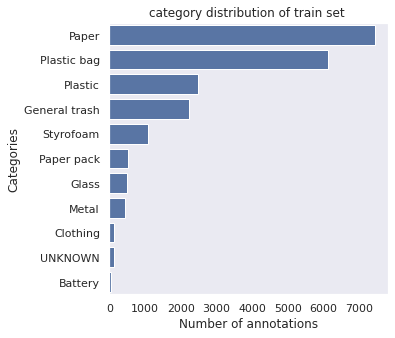

In [7]:
# Count annotations
cat_histogram = np.zeros(nr_cats,dtype=int)
for ann in anns:
    cat_histogram[ann['category_id']] += 1

# Initialize the matplotlib figure
f, ax = plt.subplots(figsize=(5,5))

# Convert to DataFrame
df = pd.DataFrame({'Categories': cat_names, 'Number of annotations': cat_histogram})
df = df.sort_values('Number of annotations', 0, False)

# Plot the histogram
plt.title("category distribution of train set ")
plot_1 = sns.barplot(x="Number of annotations", y="Categories", data=df, label="Total", color="b")

In [8]:
sorted_temp_df = df.sort_index()
sorted_df = pd.DataFrame(["Backgroud"], columns = ["Categories"])
sorted_df = sorted_df.append(sorted_temp_df, ignore_index=True)
sorted_df

,Categories,Number of annotations
0,Backgroud,NaN
1,UNKNOWN,128.0
2,General trash,2225.0
3,Paper,7448.0
4,Paper pack,527.0
5,Metal,449.0
6,Glass,488.0
7,Plastic,2472.0
8,Styrofoam,1074.0
9,Plastic bag,6114.0


# Make a CustomDataset class

In [9]:
category_names = list(sorted_df.Categories)

def get_classname(classID, cats):
    for i in range(len(cats)):
        if cats[i]['id']==classID:
            return cats[i]['name']
    return "None"

def mask2arr(mask):
    arr = np.zeros((12,mask.shape[0],mask.shape[1]))
    for i in range(12):
        arr[i,:,:] = np.where(mask==i,1,0)
    return torch.from_numpy(arr)


class CustomDataset(Dataset):
    """COCO format"""
    def __init__(self, data_dir, mode = 'train', transform = None,preprocessing=None):
        super().__init__()
        self.mode = mode
        self.transform = transform
        self.coco = COCO(data_dir)
        self.preprocessing = preprocessing
        
        
    def __getitem__(self, index: int):
        # Get the image_info using coco library
        image_id = self.coco.getImgIds(imgIds=index)
        image_infos = self.coco.loadImgs(image_id)[0]

        # Load the image using opencv
        images = cv2.imread(os.path.join(dataset_path, image_infos['file_name']))
        images = cv2.cvtColor(images, cv2.COLOR_BGR2RGB).astype(np.float32)
        images /= 255.0
        
        if (self.mode in ('train', 'val')):
            ann_ids = self.coco.getAnnIds(imgIds=image_infos['id'])
            anns = self.coco.loadAnns(ann_ids)
            # print("image_infos['id'] : {}".format(image_infos['id']) )
            # Load the categories in a variable
            cat_ids = self.coco.getCatIds()
            cats = self.coco.loadCats(cat_ids)

            # masks_size : height x width            
            masks = np.zeros((image_infos["height"], image_infos["width"]))
            for i in range(len(anns)):
                className = get_classname(anns[i]['category_id'], cats)
                pixel_value = category_names.index(className)
                masks = np.maximum(self.coco.annToMask(anns[i])*pixel_value, masks)
            masks = masks.astype(np.float32)
            # Background = 0, Unknown = 1, General trash = 2, ... , Cigarette = 11
            # for i in range(len(anns)):
            #     id=anns[i]['category_id']+1
            #     masks[id,:,:] = np.maximum(self.coco.annToMask(anns[i]), masks[id,:,:])

            # masks[0,:,:] = np.sum(masks[1:,:,:],axis=0)
            # masks[0,:,:] = np.where(masks[0,:,:]>=1,0,1)
            # masks = masks.astype(np.float32)

            # We can use Albumentations for image & mask transformation(or augmentation)
            if self.transform is not None:
                transformed = self.transform(image=images, mask=masks)
                images = transformed["image"]
                masks = transformed["mask"]
                masks =  masks.squeeze()
            if self.preprocessing:
                preprocessed = self.preprocessing(image=images, mask=masks)
                images = preprocessed['image']
                masks = preprocessed['mask']
       
           # print(masks.shape)
            masks = mask2arr(masks)
            
            return images.type(torch.FloatTensor), masks.type(torch.FloatTensor) #, image_infos
        
        if self.mode == 'test':            
            if self.transform is not None:
                transformed = self.transform(image=images)
                images = transformed["image"]
            
            return images.type(torch.FloatTensor), image_infos
    
    
    def __len__(self) -> int:        
        return len(self.coco.getImgIds())

[{'id': 0, 'name': 'UNKNOWN', 'supercategory': 'UNKNOWN'},
 {'id': 1, 'name': 'General trash', 'supercategory': 'General trash'},
 {'id': 2, 'name': 'Paper', 'supercategory': 'Paper'},
 {'id': 3, 'name': 'Paper pack', 'supercategory': 'Paper pack'},
 {'id': 4, 'name': 'Metal', 'supercategory': 'Metal'},
 {'id': 5, 'name': 'Glass', 'supercategory': 'Glass'},
 {'id': 6, 'name': 'Plastic', 'supercategory': 'Plastic'},
 {'id': 7, 'name': 'Styrofoam', 'supercategory': 'Styrofoam'},
 {'id': 8, 'name': 'Plastic bag', 'supercategory': 'Plastic bag'},
 {'id': 9, 'name': 'Battery', 'supercategory': 'Battery'},
 {'id': 10, 'name': 'Clothing', 'supercategory': 'Clothing'}]

# Create instances of CustomDataset and Assign it to DataLoader

In [10]:
train_path = os.path.join(dataset_path, 'train.json')
val_path = os.path.join(dataset_path, 'val.json')
test_path = os.path.join(dataset_path, 'test.json')

# collate_fn needs for batch
def collate_fn(batch):
    return tuple(zip(*batch))

def get_training_augmentation():
    train_transform = [
       # A.CropNonEmptyMaskIfExists(320, 480),
        A.HorizontalFlip(p=0.5),
        A.VerticalFlip(p=0.5),
        A.ShiftScaleRotate(
            scale_limit=0.5,
            rotate_limit=0,
            shift_limit=0.1,
            p=0.5,
            border_mode=0
        ),
        A.GridDistortion(p=0.5),
       # A.Resize(400, 400),
       # A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
        ToTensorV2(),
    ]
    return A.Compose(train_transform)


def get_validation_augmentation():
    """Add paddings to make image shape divisible by 32"""
    test_transform = [
        A.Resize(512, 512),
     #  A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
       ToTensorV2(),
    ]
    return A.Compose(test_transform)

test_transform = A.Compose([    
    ToTensorV2(),
])

def to_tensor(x, **kwargs):
    """
    Convert image or mask.
    """
    return x.transpose(2, 0, 1).astype('float32')


def get_preprocessing(preprocessing_fn):
    """Construct preprocessing transform
    
    Args:
        preprocessing_fn (callbale): data normalization function 
            (can be specific for each pretrained neural network)
    Return:
        transform: albumentations.Compose
    
    """
    
    _transform = [
        A.Lambda(image=preprocessing_fn),
         ToTensorV2()
       # A.Lambda(image=to_tensor, mask=to_tensor),
    ]
    return A.Compose(_transform)



In [11]:
# def mask2arr(mask):
#    arr = np.zeros((12,mask.shape[0],mask.shape[1]))
#    for i in range(12):
#      arr[i,:,:] = np.where(mask==i,1,0)
#    return arr

def arr2mask(arr):
    batch = arr.shape[0]
    mask = np.zeros((batch, arr.shape[2],arr.shape[3]))
    for b in range(batch):
        for i in range(12):
            mask[b,:,:] = np.where(arr[b,i,:,:]==1,i,mask[b,:,:])
    return mask

def arr2mask2D(arr):
  
    mask = np.zeros((arr.shape[1],arr.shape[2]))
    for i in range(12):
        mask[:,:] = np.where(arr[i,:,:]==1,i,mask[:,:])
    return mask

# Show a sample by dataloader

### train_loader
This train_loader loads the data for training.

In [12]:
# for imgs, masks, image_infos in train_loader:
#     image_infos = image_infos[0]
#     temp_images = imgs
#     temp_masks = masks
#     break

# fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(12, 12))

# print('image shape:', list(temp_images[0].shape))
# print('mask shape: ', list(temp_masks[0].shape))
# print('Unique values, category of transformed mask : \n', [{int(i),category_names[int(i)]} for i in list(np.unique(arr2mask2D(temp_masks[0])))])

# ax1.imshow(temp_images[0].permute([1,2,0]))
# ax1.grid(False)
# ax1.set_title("input image : {}".format(image_infos['file_name']), fontsize = 15)

# ax2.imshow(arr2mask2D(temp_masks[0]))
# ax2.grid(False)
# ax2.set_title("masks : {}".format(image_infos['file_name']), fontsize = 15)

# plt.show()

# Baseline model
- Here, we show you the UNet with EfficientNet-B0 encoder model. 
- We just built this baseline model with using a small model, no image augmentation, no fine-tuned hyper-parameters, etc.
- you can build your model based on this baseline model and you can improve the model in your own way.

In [13]:
!pip install git+https://github.com/qubvel/segmentation_models.pytorch

import segmentation_models_pytorch as smp

  Cloning https://github.com/qubvel/segmentation_models.pytorch to /tmp/pip-req-build-xs81u1o3
  Running command git clone -q https://github.com/qubvel/segmentation_models.pytorch /tmp/pip-req-build-xs81u1o3
  Created wheel for segmentation-models-pytorch: filename=segmentation_models_pytorch-0.1.3-cp37-none-any.whl size=83178 sha256=ffe869b30dcddc0cc9d6c6a235591ea06b2c3943b3ff7d1653ed516a20abc76f
  Stored in directory: /tmp/pip-ephem-wheel-cache-2o1oj0rp/wheels/79/3f/09/1587a252e0314d26ad242d6d2e165622ab95c95e5cfe4b942c
Successfully built segmentation-models-pytorch


In [14]:
ENCODER = 'efficientnet-b4'
ENCODER_WEIGHTS = 'imagenet'
DEVICE = 'cuda'

ACTIVATION = 'softmax2d'
model = smp.Unet(
    encoder_name=ENCODER, 
    encoder_weights=ENCODER_WEIGHTS, 
    classes=12, 
    activation=ACTIVATION,
)
model.to(DEVICE)
preprocessing_fn = smp.encoders.get_preprocessing_fn(ENCODER, ENCODER_WEIGHTS)

# Define the train, validation, test functions

In [15]:
def f_score(pr, gt, beta=1, eps=1e-7, threshold=None, activation='sigmoid'):
    """
    Args:
        pr (torch.Tensor): A list of predicted elements
        gt (torch.Tensor):  A list of elements that are to be predicted
        eps (float): epsilon to avoid zero division
        threshold: threshold for outputs binarization
    Returns:
        float: IoU (Jaccard) score
    """

    if activation is None or activation == "none":
        activation_fn = lambda x: x
    elif activation == "sigmoid":
        activation_fn = torch.nn.Sigmoid()
    elif activation == "softmax2d":
        activation_fn = torch.nn.Softmax2d()
    else:
        raise NotImplementedError(
            "Activation implemented for sigmoid and softmax2d"
        )

    pr = activation_fn(pr)

    if threshold is not None:
        pr = (pr > threshold).float()


    tp = torch.sum(gt * pr)
    fp = torch.sum(pr) - tp
    fn = torch.sum(gt) - tp

    score = ((1 + beta ** 2) * tp + eps) \
            / ((1 + beta ** 2) * tp + beta ** 2 * fn + fp + eps)

    return score


class DiceLoss(nn.Module):
    __name__ = 'dice_loss'

    def __init__(self, eps=1e-7, activation='sigmoid'):
        super().__init__()
        self.activation = activation
        self.eps = eps

    def forward(self, y_pr, y_gt):
        return 1 - f_score(y_pr, y_gt, beta=1., 
                           eps=self.eps, threshold=None, 
                           activation=self.activation)


class BCEDiceLoss(DiceLoss):
    __name__ = 'bce_dice_loss'

    def __init__(self, eps=1e-7, activation='sigmoid', lambda_dice=1.0, lambda_bce=1.0):
        super().__init__(eps, activation)
        if activation == None:
            self.bce = nn.BCELoss(reduction='mean')
        else:
            self.bce = nn.BCEWithLogitsLoss(reduction='mean')
        self.lambda_dice=lambda_dice
        self.lambda_bce=lambda_bce

    def forward(self, y_pr, y_gt):
        dice = super().forward(y_pr, y_gt)
        bce = self.bce(y_pr, y_gt)
        return (self.lambda_dice*dice) + (self.lambda_bce* bce)

In [16]:
# define the evaluation function
# https://github.com/wkentaro/pytorch-fcn/blob/master/torchfcn/utils.py
import numpy as np

def _fast_hist(label_true, label_pred, n_class):
    mask = (label_true >= 0) & (label_true < n_class)
    hist = np.bincount(
        n_class * label_true[mask].astype(int) +
        label_pred[mask], minlength=n_class ** 2).reshape(n_class, n_class)
    return hist


def label_accuracy_score(label_trues, label_preds, n_class=12):
    """Returns accuracy score evaluation result.
      - overall accuracy
      - mean accuracy
      - mean IU
      - fwavacc
    """
    # label_trues = arr2mask(label_trues.detach().cpu().numpy())
    # label_preds = torch.argmax(label_preds.squeeze(), dim=1).detach().cpu().numpy()
    hist = np.zeros((n_class, n_class))
    for lt, lp in zip(label_trues, label_preds):
        hist += _fast_hist(lt.flatten(), lp.flatten(), n_class)
    acc = np.diag(hist).sum() / hist.sum()
    with np.errstate(divide='ignore', invalid='ignore'):
        acc_cls = np.diag(hist) / hist.sum(axis=1)
    acc_cls = np.nanmean(acc_cls)
    with np.errstate(divide='ignore', invalid='ignore'):
        iu = np.diag(hist) / (
            hist.sum(axis=1) + hist.sum(axis=0) - np.diag(hist)
        )
    mean_iu = np.nanmean(iu)

    return  mean_iu

# Define the function to save the model

In [17]:
train_dataset = CustomDataset(data_dir=train_path, mode='train', transform=get_training_augmentation())  #,preprocessing=get_preprocessing(preprocessing_fn)


# validation dataset
val_dataset = CustomDataset(data_dir=val_path, mode='val', transform=get_validation_augmentation()) #,preprocessing=get_preprocessing(preprocessing_fn)


# test dataset
test_dataset = CustomDataset(data_dir=test_path, mode='test', transform=test_transform) #,preprocessing=get_preprocessing(preprocessing_fn)



train_loader = torch.utils.data.DataLoader(dataset=train_dataset, 
                                           batch_size=batch_size,
                                           shuffle=True,
                                           num_workers=1,
                                          )

val_loader = torch.utils.data.DataLoader(dataset=val_dataset, 
                                         batch_size=batch_size,
                                         shuffle=True,
                                         num_workers=1,
                                        )

test_loader = torch.utils.data.DataLoader(dataset=test_dataset,
                                          batch_size=4,
                                          num_workers=1,
                                          collate_fn=collate_fn)

loading annotations into memory...
Done (t=3.33s)
creating index...
index created!
loading annotations into memory...
Done (t=0.67s)
creating index...
index created!
loading annotations into memory...
Done (t=0.02s)
creating index...
index created!


In [18]:
from torch.optim.lr_scheduler import StepLR, ReduceLROnPlateau, CosineAnnealingLR

#model = smp.Unet(encoder_name='efficientnet-b4', classes=12 , encoder_weights="imagenet")
loss = BCEDiceLoss()
# criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam([
    {'params': model.decoder.parameters(), 'lr': 5e-2}, 
    {'params': model.encoder.parameters(), 'lr': 5e-3},  
])
#scheduler = ReduceLROnPlateau(optimizer, factor=0.15, patience=2)

metrics = [
    #label_accuracy_score,      
    smp.utils.metrics.IoU(threshold=0.7),
]

In [19]:
train_epoch = smp.utils.train.TrainEpoch(
    model, 
    loss=loss, 
    metrics=metrics, 
    optimizer=optimizer,
    device=DEVICE,
    verbose=True,
)

valid_epoch = smp.utils.train.ValidEpoch(
    model, 
    loss=loss, 
    metrics=metrics, 
    device=DEVICE,
    verbose=True,
)

In [20]:
max_score = 0

for i in range(0, 15):
    print('\nEpoch: {}'.format(i))
    train_logs = train_epoch.run(train_loader)
    valid_logs = valid_epoch.run(val_loader)
    
    # do something (save model, change lr, etc.)
    if max_score < valid_logs['iou_score']:
        max_score = valid_logs['iou_score']
        torch.save(model, './best_model.pth')
        print('Model saved!')
        
    if i == 5:
        optimizer.param_groups[0]['lr'] = 1e-3
        print('Decrease decoder learning rate to 1e-3!')

    if i == 10:
      optimizer.param_groups[0]['lr'] = 1e-5
      print('Decrease decoder learning rate to 1e-5!')
      



Epoch: 0
valid: 100%|██████████| 82/82 [00:51<00:00,  1.58it/s, bce_dice_loss - 1.501, iou_score - 0.5652]
Model saved!

Epoch: 1
valid: 100%|██████████| 82/82 [00:50<00:00,  1.61it/s, bce_dice_loss - 1.498, iou_score - 0.5874]
Model saved!

Epoch: 2
valid: 100%|██████████| 82/82 [00:51<00:00,  1.61it/s, bce_dice_loss - 1.499, iou_score - 0.5788]

Epoch: 3
valid: 100%|██████████| 82/82 [00:51<00:00,  1.59it/s, bce_dice_loss - 1.491, iou_score - 0.6532]
Model saved!

Epoch: 4
valid: 100%|██████████| 82/82 [00:47<00:00,  1.73it/s, bce_dice_loss - 1.494, iou_score - 0.6245]

Epoch: 5
valid: 100%|██████████| 82/82 [00:50<00:00,  1.61it/s, bce_dice_loss - 1.495, iou_score - 0.6159]
Decrease decoder learning rate to 1e-3!

Epoch: 6
train:  11%|█         | 36/328 [00:43<05:51,  1.20s/it, bce_dice_loss - 1.493, iou_score - 0.6306]


KeyboardInterrupt: ignored

# Create instances of loss function and optimizer

# Train

# Load the saved model 

In [ ]:
# import segmentation_models_pytorch as smp

# # path of saved best model
# model_path = './saved/best_model.pt'

# # initialize the model
# model = smp.Unet(encoder_name='efficientnet-b1', classes=12 , encoder_weights=None, activation=None).to(device)

# # load the saved best model
# checkpoint = torch.load(model_path, map_location=device)
# state_dict = checkpoint.state_dict()
# model.load_state_dict(state_dict)

# # switch to evaluation mode
# model.eval()
# print('')

 # Inference
 Infer one sample and show the our model prediction result to make sure our model works correctly.

In [ ]:
# outs=model(temp_images[0].cuda().unsqueeze(0))
# oms = torch.argmax(outs, dim=1).detach().cpu().numpy()

In [ ]:
# np.stack(temp_masks).shape

In [ ]:
def _threshold(x, threshold=None):
    if threshold is not None:
        return (x > threshold).type(x.dtype)
    else:
        return x

In [ ]:
for imgs, image_infos in test_loader:
    image_infos = image_infos
    temp_images = imgs
    
    model.eval()
    # inference
    outs = model(torch.stack(temp_images).to(device))
    outs = _threshold(outs,0.7)
    oms = torch.argmax(outs.squeeze(), dim=1).detach().cpu().numpy()
    
   
    for i in range(4):
        fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(16, 16))

        print('Shape of Original Image :', list(temp_images[i].shape))
        print('Shape of Predicted : ', list(oms[i].shape))
        print('Unique values, category of transformed mask : \n', [{int(i),category_names[int(i)]} for i in list(np.unique(oms[i]))])

        # Original image
        ax1.imshow(temp_images[i].permute([1,2,0]))
        ax1.grid(False)
        ax1.set_title("Original image : {}".format(image_infos[i]['file_name']), fontsize = 15)

        # Predicted mask
        ax2.imshow(oms[i])
        ax2.grid(False)
        ax2.set_title("Predicted : {}".format(image_infos[i]['file_name']), fontsize = 15)

        plt.show()


In [ ]:


# val_dataset = CustomDataset(data_dir=val_path, mode='val', transform=get_validation_augmentation(),preprocessing=get_preprocessing(preprocessing_fn))

# val_loader = torch.utils.data.DataLoader(dataset=val_dataset, 
#                                          batch_size=2,
#                                          shuffle=True,
#                                          num_workers=1,
#                                         )
# for imgs, masks in val_loader:
#     mask = arr2mask(masks)
#     temp_images = imgs
#     model.eval()
#     # inference
#     outs = model(temp_images.to(device))
#     outs = _threshold(outs,0.8)
#     oms = torch.argmax(outs.squeeze(), dim=1).detach().cpu().numpy()
    
   
#     for i in range(2):
#         fig, (ax1, ax2,ax3) = plt.subplots(nrows=1, ncols=3, figsize=(16, 16))

#         print('Shape of Original Image :', list(temp_images[i].shape))
#         print('Shape of Predicted : ', list(oms[i].shape))
#         print('Unique values, category of transformed mask : \n', [{int(i),category_names[int(i)]} for i in list(np.unique(oms[i]))])

#         # Original image
#         ax1.imshow(temp_images[i].permute([1,2,0]))
#         ax1.grid(False)
#         #ax1.set_title("Original image : {}".format(image_infos[i]['file_name']), fontsize = 15)

#         # Predicted mask
#         ax2.imshow(oms[i])
#         ax2.grid(False)
        
#         ax3.imshow(mask[i])
#         ax3.grid(False)
#         #ax2.set_title("Predicted : {}".format(image_infos[i]['file_name']), fontsize = 15)

#         plt.show()

In [ ]:
mIoU_list = []
for imgs, masks in val_loader:
    outs = model(imgs.to(device))
    outs = _threshold(outs,0.7)
    oms = torch.argmax(outs.squeeze(), dim=1).detach().cpu().numpy()
    masks = arr2mask(masks)
    mIoU = label_accuracy_score(masks,oms)
    mIoU_list.append(mIoU)
    #print('mIoU: {:.4f}'.format(mIoU))


print('mIoU: {:.4f}'.format(np.mean(mIoU_list)))


# Define the test function to submit model prediction

In [ ]:
def test(model, data_loader, device):
    size = 256
    transform = A.Compose([A.Resize(256, 256)])
    print('Start prediction.')
    model.eval()
    
    file_name_list = []
    preds_array = np.empty((0, size*size), dtype=np.long)
    
    with torch.no_grad():
        for step, (imgs, image_infos) in enumerate(test_loader):

            # inference (512 x 512)
            outs = model(torch.stack(imgs).to(device))
            outs = _threshold(outs,0.7)
            oms = torch.argmax(outs.squeeze(), dim=1).detach().cpu().numpy()
            
            # resize (256 x 256)
            temp_mask = []
            for img, mask in zip(np.stack(temp_images), oms):
                transformed = transform(image=img, mask=mask)
                mask = transformed['mask']
                temp_mask.append(mask)

            oms = np.array(temp_mask)
            
            oms = oms.reshape([oms.shape[0], size*size]).astype(int)
            preds_array = np.vstack((preds_array, oms))
            
            file_name_list.append([i['file_name'] for i in image_infos])
    print("End prediction.")
    file_names = [y for x in file_name_list for y in x]
    
    return file_names, preds_array

# Make a submission

In [ ]:
# inference
file_names, preds = test(model, test_loader, device)
submission = pd.DataFrame()

submission['image_id'] = file_names
submission['PredictionString'] = [' '.join(str(e) for e in string.tolist()) for string in preds]

# save submission.csv
submission.to_csv("submission.csv", index=False)

# Submit to the leaderboard

You have to submit your 'submission.csv' file to the leaderboard. You can connect directly to the submission page using the link below.
http://dev.stages.ai/competitions/15/submission